# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np


import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
train = pd.read_parquet('./dataset/train_temp.parquet.gzip') 
test = pd.read_parquet('./dataset/test_temp.parquet.gzip') 

In [6]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [7]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
7365884,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:03,WELL-00001,1
7365885,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:04,WELL-00001,1
7365886,0.0,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0,2014-01-24 09:33:05,WELL-00001,1
7365887,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:06,WELL-00001,1
7365888,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:07,WELL-00001,1


## Models

In [8]:
with open('./models/pipeline_iForest.pkl', 'rb') as f:
    iforest = pickle.load(f) 

with open('./models/pipeline_PCA.pkl', 'rb') as f:
    pca = pickle.load(f) 

with open('./models/pipeline_LODA.pkl', 'rb') as f:
    loda = pickle.load(f) 

with open('./models/pipeline_SGDOSVM.pkl', 'rb') as f:
    sgdocsvm = pickle.load(f) 

In [9]:
iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.05, random_state=42))])

In [16]:
y_pred = iforest.predict(test[VARS])
test['iForest'] = np.where(y_pred == -1, 1, 0)  

y_pred = sgdocsvm.predict(test[VARS])
test['OCSVM'] = np.where(y_pred == -1, 1, 0)  

test['PCA'] = pca.predict(test[VARS])

test['LODA'] = loda.predict(test[VARS])

In [33]:
y_pred = iforest.predict(train[VARS])
train['iForest'] = np.where(y_pred == -1, 1, 0)  

y_pred = sgdocsvm.predict(train[VARS])
train['OCSVM'] = np.where(y_pred == -1, 1, 0)  

train['PCA'] = pca.predict(train[VARS])

train['LODA'] = loda.predict(train[VARS])

In [28]:
test['scores_iforest']=-iforest.decision_function(test[VARS])

test['scores_pca']=pca.decision_function(test[VARS])

test['scores_loda']=loda.decision_function(test[VARS])

test['scores_ocsvm']=-sgdocsvm.decision_function(test[VARS])

In [34]:
train['scores_iforest']=-iforest.decision_function(train[VARS])

train['scores_pca']=pca.decision_function(train[VARS])

train['scores_loda']=loda.decision_function(train[VARS])

train['scores_ocsvm']=-sgdocsvm.decision_function(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.62497   0.76920   1493608
           1    0.56521   1.00000   0.72222    728192

    accuracy                        0.74788   2221800
   macro avg    0.78261   0.81248   0.74571   2221800
weighted avg    0.85750   0.74788   0.75381   2221800

Specificity: 0.6249658544946197
Gini:  0.6249658544946197
ROC AUC::  0.8124829272473099


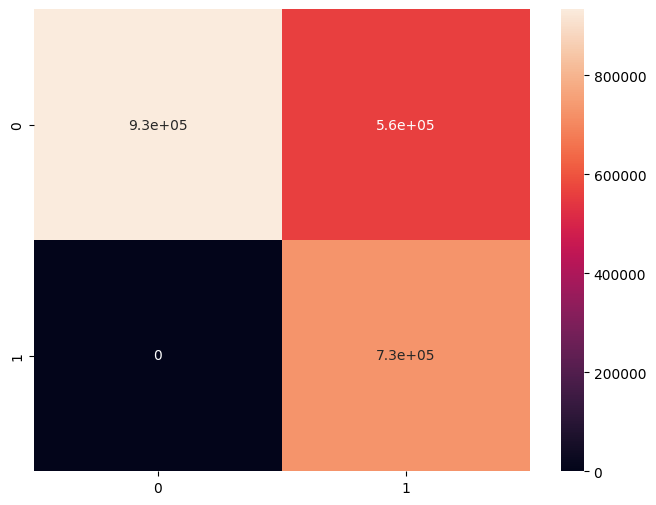

In [17]:
metrics(test.target, test.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.99021   0.99508   1493608
           1    0.98031   1.00000   0.99006    728192

    accuracy                        0.99342   2221800
   macro avg    0.99016   0.99510   0.99257   2221800
weighted avg    0.99355   0.99342   0.99343   2221800

Specificity: 0.990209613231852
Gini:  0.9902096132318519
ROC AUC::  0.9951048066159259


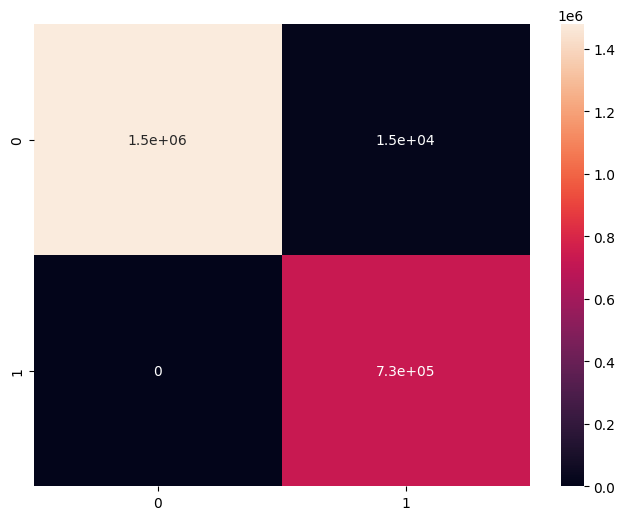

In [18]:
metrics(test.target, test.PCA)

Classification Report: 
               precision    recall  f1-score   support

           0    0.92712   0.99033   0.95768   1493608
           1    0.97694   0.84032   0.90350    728192

    accuracy                        0.94117   2221800
   macro avg    0.95203   0.91533   0.93059   2221800
weighted avg    0.94345   0.94117   0.93992   2221800

Specificity: 0.9903314658196796
Gini:  0.830652425127115
ROC AUC::  0.9153262125635575


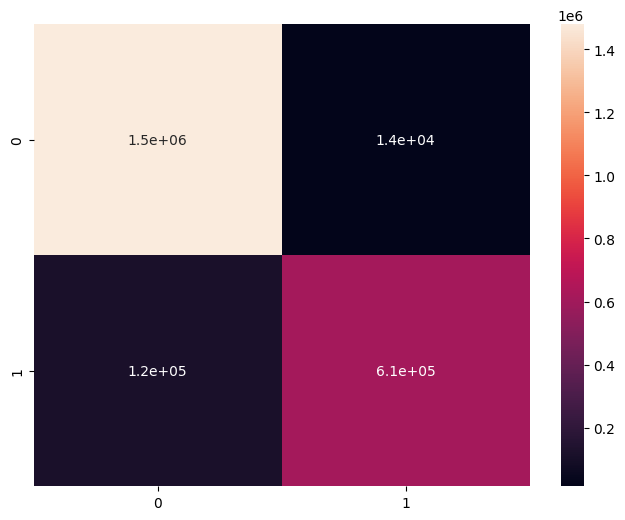

In [19]:
metrics(test.target, test.LODA)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.86333   0.92665   1493608
           1    0.78105   1.00000   0.87707    728192

    accuracy                        0.90812   2221800
   macro avg    0.89052   0.93166   0.90186   2221800
weighted avg    0.92824   0.90812   0.91040   2221800

Specificity: 0.8633269237979443
Gini:  0.8633269237979442
ROC AUC::  0.9316634618989721


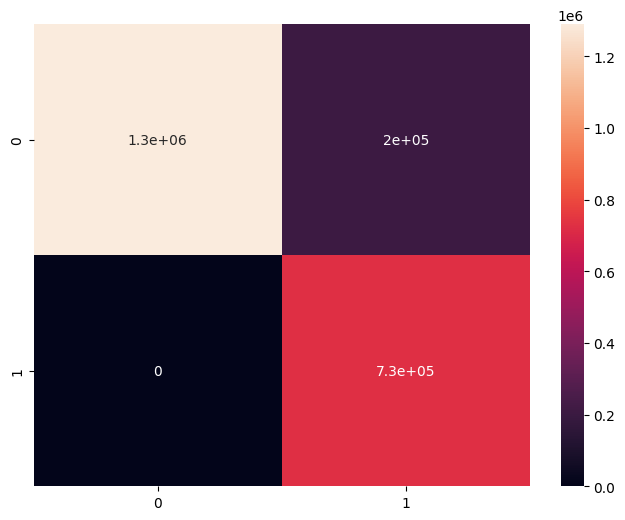

In [20]:
metrics(test.target, test.OCSVM)

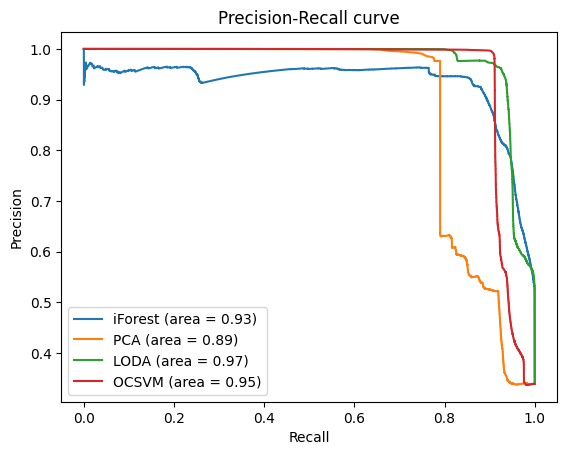

In [35]:
# Computar a precisão e o recall para cada modelo
precision_model0, recall_model0, _ = precision_recall_curve(train.target, train.scores_iforest)
precision_model1, recall_model1, _ = precision_recall_curve(train.target, train.scores_pca)
precision_model2, recall_model2, _ = precision_recall_curve(train.target, train.scores_loda)
precision_model3, recall_model3, _ = precision_recall_curve(train.target, train.scores_ocsvm)

# Calcular a pontuação de precisão média (AUC) para cada modelo
average_precision_model0 = average_precision_score(train.target, train.scores_iforest)
average_precision_model1 = average_precision_score(train.target, train.scores_pca)
average_precision_model2 = average_precision_score(train.target, train.scores_loda)
average_precision_model3 = average_precision_score(train.target, train.scores_ocsvm)

# Plotar as curvas de precisão-recall para cada modelo
plt.plot(recall_model0, precision_model0, label='iForest (area = {0:0.2f})'.format(average_precision_model0))
plt.plot(recall_model1, precision_model1, label='PCA (area = {0:0.2f})'.format(average_precision_model1))
plt.plot(recall_model2, precision_model2, label='LODA (area = {0:0.2f})'.format(average_precision_model2))
plt.plot(recall_model3, precision_model3, label='OCSVM (area = {0:0.2f})'.format(average_precision_model3))

# Adicionar título e labels aos eixos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()

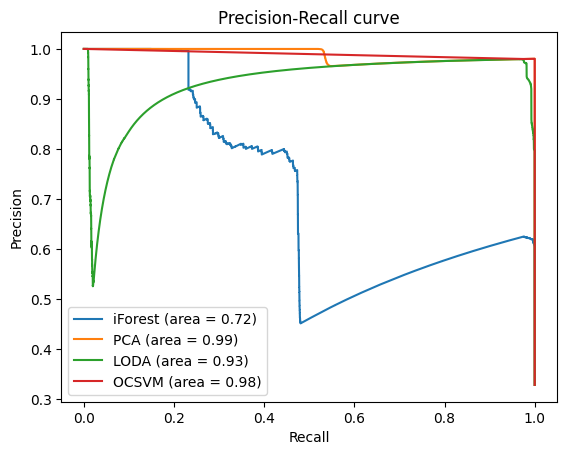

In [30]:
# Computar a precisão e o recall para cada modelo
precision_model0, recall_model0, _ = precision_recall_curve(test.target, test.scores_iforest)
precision_model1, recall_model1, _ = precision_recall_curve(test.target, test.scores_pca)
precision_model2, recall_model2, _ = precision_recall_curve(test.target, test.scores_loda)
precision_model3, recall_model3, _ = precision_recall_curve(test.target, test.scores_ocsvm)

# Calcular a pontuação de precisão média (AUC) para cada modelo
average_precision_model0 = average_precision_score(test.target, test.scores_iforest)
average_precision_model1 = average_precision_score(test.target, test.scores_pca)
average_precision_model2 = average_precision_score(test.target, test.scores_loda)
average_precision_model3 = average_precision_score(test.target, test.scores_ocsvm)

# Plotar as curvas de precisão-recall para cada modelo
plt.plot(recall_model0, precision_model0, label='iForest (area = {0:0.2f})'.format(average_precision_model0))
plt.plot(recall_model1, precision_model1, label='PCA (area = {0:0.2f})'.format(average_precision_model1))
plt.plot(recall_model2, precision_model2, label='LODA (area = {0:0.2f})'.format(average_precision_model2))
plt.plot(recall_model3, precision_model3, label='OCSVM (area = {0:0.2f})'.format(average_precision_model3))

# Adicionar título e labels aos eixos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()

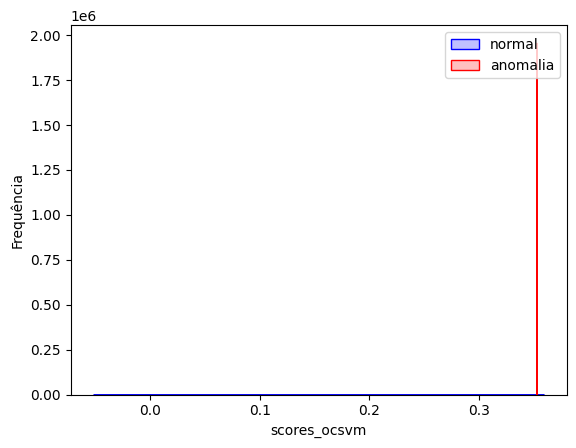

In [32]:
g = sns.kdeplot(test["scores_ocsvm"][(test["target"] == 0) & (test["scores_ocsvm"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_ocsvm"][(test["target"] == 1) & (test["scores_ocsvm"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_ocsvm")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

### Explainable

In [23]:
test_sample = test.sample(frac=0.05, random_state=45)
test_sample_shap = test_sample[VARS]
test_sample_shap.shape

(111090, 7)

In [87]:
test_sample_shap.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
1365893,-6.887865e+06,9663066.0,118.4939,1590471.0,83.71794,-137539.4,0.0
10740299,-1.180116e+42,20787460.0,117.9016,10101000.0,70.89400,4048624.0,0.0
1472095,-6.887865e+06,9654070.0,118.4533,1424296.0,83.07838,-147999.8,0.0
10746609,-1.180116e+42,20787460.0,117.9162,10094150.0,70.92538,4061716.0,0.0
1631158,-6.887865e+06,9615695.0,118.4985,1213798.0,83.28349,-142259.4,0.0


In [88]:
exp = shap.TreeExplainer(iforest[2]) #Explainer
test_transform = iforest[1].transform((iforest[0].transform(test_sample_shap)))
shap_values = exp.shap_values(test_transform)  #Calculate SHAP values
shap.initjs()

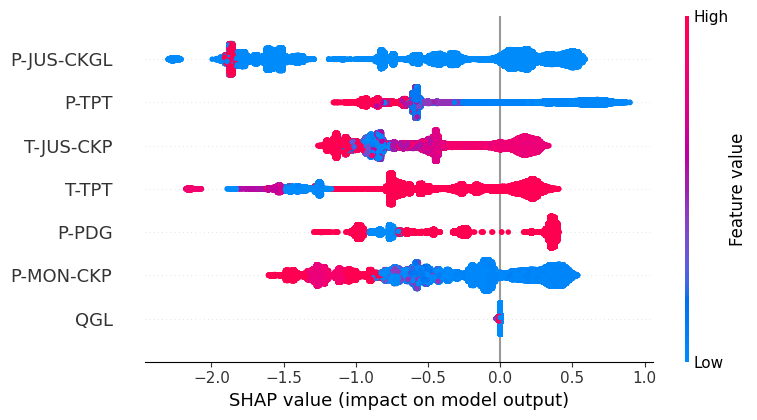

In [89]:
shap.summary_plot(shap_values, test_transform)

In [90]:
test_sample_shap.head(5)

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL
1365893,-6.887865e+06,9663066.0,118.4939,1590471.0,83.71794,-137539.4,0.0
10740299,-1.180116e+42,20787460.0,117.9016,10101000.0,70.89400,4048624.0,0.0
1472095,-6.887865e+06,9654070.0,118.4533,1424296.0,83.07838,-147999.8,0.0
10746609,-1.180116e+42,20787460.0,117.9162,10094150.0,70.92538,4061716.0,0.0
1631158,-6.887865e+06,9615695.0,118.4985,1213798.0,83.28349,-142259.4,0.0


In [94]:
shap.force_plot(exp.expected_value, shap_values[250],features =test_transform.iloc[250,:] ,feature_names =test_transform.columns)

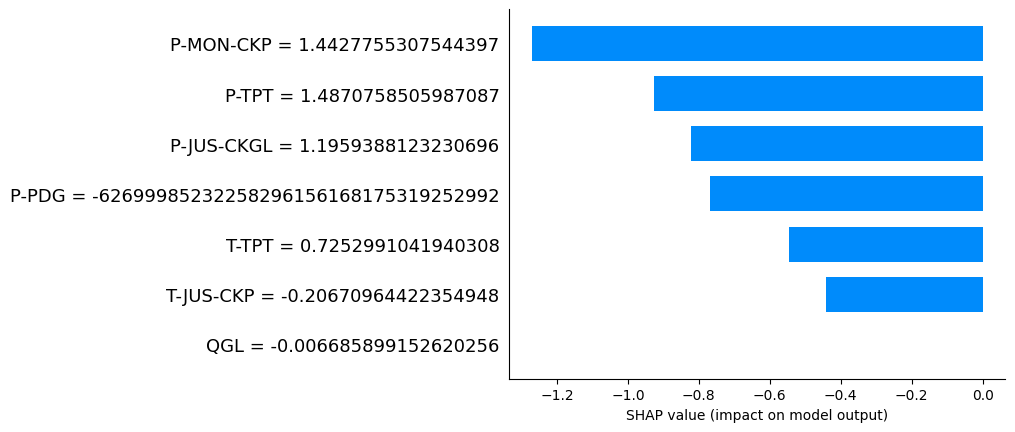

In [30]:
shap.bar_plot(shap_values[3],features =test_transform.iloc[1,:] ,feature_names =test_transform.columns)

## TSNE

In [24]:
train_sample_tsne = train.sample(frac=0.002, random_state=48)
train_sample_tsne.shape

(17774, 12)

In [25]:
train_sample_tsne_transformed = iforest[1].transform((iforest[0].transform(train_sample_tsne[VARS])))

In [26]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000, n_jobs=-1)

In [27]:
X_reduce = tsne.fit_transform(train_sample_tsne_transformed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17774 samples in 0.164s...
[t-SNE] Computed neighbors for 17774 samples in 0.901s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17774
[t-SNE] Computed conditional probabilities for sample 2000 / 17774
[t-SNE] Computed conditional probabilities for sample 3000 / 17774
[t-SNE] Computed conditional probabilities for sample 4000 / 17774
[t-SNE] Computed conditional probabilities for sample 5000 / 17774
[t-SNE] Computed conditional probabilities for sample 6000 / 17774
[t-SNE] Computed conditional probabilities for sample 7000 / 17774
[t-SNE] Computed conditional probabilities for sample 8000 / 17774
[t-SNE] Computed conditional probabilities for sample 9000 / 17774
[t-SNE] Computed conditional probabilities for sample 10000 / 17774
[t-SNE] Computed conditional probabilities for sample 11000 / 17774
[t-SNE] Computed conditional probabilities for sample 12000 / 17774
[t-SNE] Computed conditional probabilities for sam

In [28]:
tsne_result_df = pd.DataFrame({'tsne_1': X_reduce[:,0], 'tsne_2': X_reduce[:,1], 'tsne_3': X_reduce[:,0]})

tsne_result_df = tsne_result_df.reset_index(drop=True)
data_tsne = train_sample_tsne.reset_index(drop=True)

data_tsne = pd.concat([data_tsne, tsne_result_df], axis=1)
# data2= data2[data2['CONJUNTO']=='test']
data_tsne.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target,iForest,scores_forest,tsne_1,tsne_2,tsne_3
0,0.0,7692329.0,115.98580,1392323.0,71.00699,2332164.0,0.000000,2017-02-15 22:05:03,WELL-00002,0,0,0.489431,3.590950,-2.340828,3.590950
1,23428230.0,13984480.0,55.97573,2607340.0,37.41902,20036340.0,1.875875,2017-09-23 19:47:16,WELL-00014,1,1,0.669879,31.532644,-5.972567,31.532644
2,0.0,14229420.0,116.58940,6109810.0,69.11475,3007766.0,0.000000,2017-05-28 10:25:30,WELL-00001,0,0,0.437528,6.107171,-11.446284,6.107171
3,32308910.0,12881370.0,86.08977,5798349.0,30.51202,16627500.0,0.000000,2014-03-15 12:00:10,WELL-00017,1,1,0.684785,19.558762,4.912278,19.558762
4,23406160.0,13769710.0,56.46887,2372113.0,37.57725,19696220.0,1.503259,2017-09-15 21:14:52,WELL-00014,1,1,0.666385,24.816570,-16.530167,24.816570


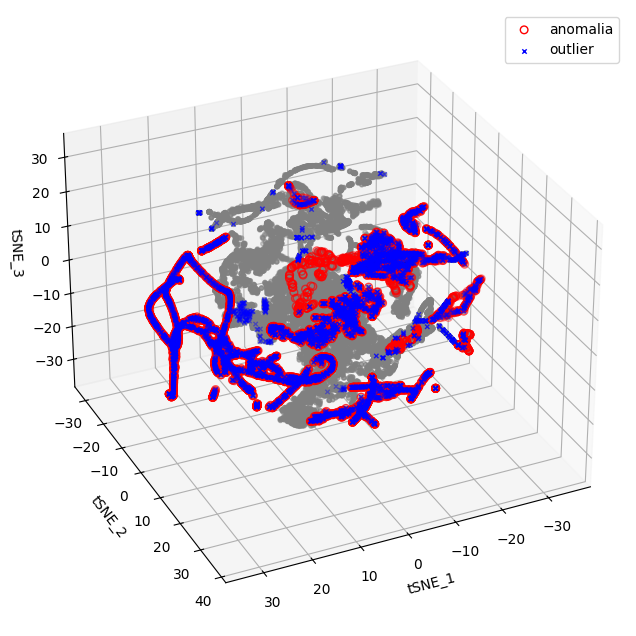

In [44]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, c='grey')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data_tsne.target == 1, 0], X_reduce[data_tsne.target == 1, 1], zs=X_reduce[data_tsne.target == 1, 2],
           lw=1, facecolors="none", edgecolors="red", s=30, label="anomalia")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data_tsne.iForest == 1, 0], X_reduce[data_tsne.iForest == 1, 1], zs=X_reduce[data_tsne.iForest == 1, 2],
           lw=1, s=10, marker="x", c="blue", label="outlier")

ax.legend()

# Rotacionar o gráfico
ax.view_init(elev=30, azim=65)  # Elevação e azimute em graus

plt.show()